In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import pandas as pd
import os
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import itertools


### Data exploration
['AS14.01', 'AS14.02', 'AS14.03', 'AS14.05', 'AS14.06', 'AS14.07',
       'AS14.08', 'AS14.09', 'AS14.12', 'AS14.13', 'AS14.14', 'AS14.15',
       'AS14.16', 'AS14.17', 'AS14.19', 'AS14.20', 'AS14.23', 'AS14.24',
       'AS14.25', 'AS14.26', 'AS14.27', 'AS14.28', 'AS14.29', 'AS14.30',
       'AS14.31', 'AS14.32', 'AS14.33']

In [3]:
df = pd.read_csv('dataset_mood_smartphone.csv')
df.head()

df.isna().sum()

Unnamed: 0      0
id              0
time            0
variable        0
value         202
dtype: int64

In [4]:
df["id_num"] = df["id"].apply(lambda x: int(x.split(".")[1]))
print(df["id_num"].unique())
df["id"].unique()

# convert time to datetime
df["time"] = pd.to_datetime(df["time"])


[ 1  2  3  5  6  7  8  9 12 13 14 15 16 17 19 20 23 24 25 26 27 28 29 30
 31 32 33]


## Time ranges

In [5]:
def get_time_descriptives(df, participant: int):
    """
    Get time descriptives for a given participant.
    """
    # Filter for the participant
    df_person = df[df["id_num"] == participant].copy()

    # rename time into datetime
    # print(df_person.columns) 
    
    # Group by variable and compute descriptive statistics
    stats = df_person.groupby("variable")["time"].agg(
        count_non_missing = "count",
        min_time = "min",
        max_time = "max"
    )
    # Count missing values per variable
    stats["n_missing"] = df_person.groupby("variable")["time"].apply(lambda x: x.isna().sum())
    # Calculate the time range (difference between max and min)
    stats["time_range"] = stats["max_time"] - stats["min_time"]
    
    # Optionally, reset the index for a nicer display
    stats = stats.reset_index()
    return stats


def plot_time_ranges(df, participant, save_fig=True, show_plot=True):
    """
    Plot the time range for each variable for a given participant.
    """
    # Get descriptive stats for plotting
    stats = get_time_descriptives(df, participant)
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(12, 0.3 * len(stats)))  # Adjust height based on number of variables
    
    # Loop over each variable to draw its time range as a horizontal line
    earliest = stats["min_time"].min()
    latest = stats["max_time"].max()
    for idx, row in stats.iterrows():
        ax.hlines(y=idx, xmin=row["min_time"], xmax=row["max_time"], color='blue', lw=2)

        # Optionally, mark the endpoints
        if row["min_time"] == earliest:
            ax.plot(row["min_time"], idx, "o", color='purple')
        else:
            ax.plot(row["min_time"], idx, "o", color='green')
        if row["max_time"] == latest:
            ax.plot(row["max_time"], idx, "o", color='darkred')
        else:
            ax.plot(row["max_time"], idx, "o", color='red')

    # higlight background between the earliest and latest time of mood
    earliest_mood = stats[stats["variable"] == "mood"]["min_time"].values[0]
    latest_mood = stats[stats["variable"] == "mood"]["max_time"].values[0]
    ax.axvspan(earliest_mood, latest_mood, alpha=0.1, color='yellow')


    # get the earliest and latest time and write it to the plot

    plt.text(earliest, 5, earliest, color='black', fontsize=12)
    plt.text(latest, 5, latest, color='black', fontsize=12)
    
    # line for earliest and latest time
    ax.axvline(earliest, color='black', linestyle='--', lw=1)
    ax.axvline(latest, color='black', linestyle='--', lw=1)
    
    # Customize y-axis with variable names
    ax.set_yticks(range(len(stats)))
    ax.set_yticklabels(stats["variable"])
    ax.set_xlabel("Time")
    ax.set_title("Time Range per Variable for Participant {}".format(participant))


    plt.tight_layout()


    # save figure
    if save_fig:
        if not os.path.exists("figures/time_ranges_per_variable"):
            os.makedirs("figures/time_ranges_per_variable")
        plt.savefig(f"figures/time_ranges_per_variable/time_range_plot_p{participant}.png")
    
    # add one legend for all lines

    if show_plot:
        plt.show()
    else:
        plt.close()



for person in df["id_num"].unique():
    # print(f"Participant {person}")
    stats = get_time_descriptives(df, person)
    # print(stats)
    plot_time_ranges(df, person, save_fig=True, show_plot=False)




## Create daily pivot for particiapnt per day

In [6]:

def create_daily_pivot(df, participant="all", return_dict=False, counts=True):
    """
    Create a daily pivot table for a given participant or all participants or list of participants.
    
    Each row corresponds to a day (from the earliest to the latest day the participant has data),
    each column corresponds to a variable, and if multiple datapoints occur on a given day,
    the value is aggregated as the mean. Days with no data for a variable are represented as NaN.
    
    Parameters:
        df (pd.DataFrame): DataFrame containing at least the columns 'id_num', 'time', 
                           'variable', and 'value'. The 'time' column should be in datetime format.
        participant: Either "all" (to process all participants), a single participant id, or a list of participant ids.
        return_dict (bool): If True, returns a dictionary of pivot tables (keyed by participant).
                            Otherwise, returns a single DataFrame with 'id_num' and 'day' as columns.
        counts (bool): If True, includes a count of the number of values for each variable per day.
    
    Returns:
        Either a dict mapping participant IDs to their daily pivot table or a combined DataFrame.
    """
    # Determine the list of participant IDs to process
    if participant == "all":
        participants = df["id_num"].unique()
    elif isinstance(participant, list):
        participants = participant
    else:
        participants = [participant]
        
    # Ensure the time column is in datetime format
    df_copy = df.copy()
    if not pd.api.types.is_datetime64_any_dtype(df_copy["time"]):
        df_copy["time"] = pd.to_datetime(df_copy["time"])
    
    # Create a column with just the day (flooring the datetime to day)
    df_copy["day"] = df_copy["time"].dt.floor("D")
    
    pivot_dict = {}
    pivot_list = []
    
    # Process each participant separately
    for part in participants:
        df_part = df_copy[df_copy["id_num"] == part].copy()

        # get a count of the number of values of variable per day
        # df_part["comprising_of"] = df_part.groupby(["day", "variable"])["value"].transform("count")

        # select the mean aggregation columns, time values should be aggregated by sum
        mean_agg = ["mood", "circumplex.valence", "circumplex.arousal"] # not sure about activity
        sum_agg = [col for col in df_part["variable"].unique() if col not in mean_agg + ["id_num", "time", "day"]]
        
        # Create a new DataFrame with the selected columns
        df_part_sum = df_part[df_part["variable"].isin(sum_agg)].copy()
        pivot_sum = df_part_sum.pivot_table(index="day",
                                            columns="variable", 
                                            values="value", 
                                            aggfunc="sum")

        # only non-nan values are averaged
        df_part_mean = df_part[df_part["variable"].isin(mean_agg)].copy()
        pivot_mean = df_part_mean.pivot_table(index="day",
                                              columns="variable", 
                                              values="value", 
                                              aggfunc="mean")
    
        # get the count of the number of values comprising the variable per day
        pivot_count = df_part.pivot_table(index="day",
                                    columns="variable",
                                    values="value",
                                    aggfunc="count")

        # add maximum values in a day
        max_agg = ["activity", "circumplex.valence", "circumplex.arousal"]
        df_part_max = df_part[df_part["variable"].isin(max_agg)].copy()
        pivot_max = df_part_max.pivot_table(index="day",
                                        columns="variable",
                                        values="value",
                                        aggfunc="max")

        # add the minimum values in a day
        min_agg = ["circumplex.valence", "circumplex.arousal"]
        df_part_min = df_part[df_part["variable"].isin(min_agg)].copy()
        pivot_min = df_part_min.pivot_table(index="day",
                                        columns="variable",
                                        values="value",
                                        aggfunc="min")


        #nans are 0
        pivot_count = pivot_count.fillna(0) # NOT SURE ABOUT THIS
        pivot_count = pivot_count.add_suffix("_count")

        pivot_max = pivot_max.add_suffix("_max")
        pivot_min = pivot_min.add_suffix("_min")



        # Combine the two pivot tables
        pivot = pd.concat([pivot_sum, pivot_mean, pivot_max, pivot_min], axis=1)
        # Pandas aligns the data based on the index (which here represents the days).
        # The union of the indices is taken, and any missing data for a particular day in one of the tables is filled with NaN. 
        # The same applies when you concatenate the count pivot table. 
        # This means that even if the individual pivot tables have different numbers of rows, the concatenation will produce a DataFrame covering all days from the union of the indices.
        if counts:
            pivot = pd.concat([pivot, pivot_count], axis=1)
                                            
        # Create a complete date range from the earliest to the latest day for this participant
        full_range = pd.date_range(start=df_part["day"].min(), end=df_part["day"].max(), freq="D")
        pivot = pivot.reindex(full_range)
        pivot.index.name = "day"
        
        # Convert index to a column and add participant id
        pivot = pivot.reset_index()
        pivot["id_num"] = part

        # reorder the columns
        desired_order = ["id_num", "day", "mood", "screen", "activity", "circumplex.valence", "circumplex.arousal", "call", "sms"]
        other_columns = [p for p in pivot.columns if p not in desired_order and not p.endswith("_count") and not p.endswith("_max") and not p.endswith("_min")]
        new_order = desired_order + other_columns

        # add the counts to the new order
        final_order = []
        for col in new_order:
            final_order.append(col)
            if col not in ["id_num", "day"]:
                if counts:
                    final_order.append(f"{col}_count")
                if col in ["circumplex.valence", "circumplex.arousal"]:
                    final_order.append(f"{col}_min")
                if col in ["activity", "circumplex.valence", "circumplex.arousal"]:
                    final_order.append(f"{col}_max")

        pivot = pivot[final_order]
        
        # print("final columns", pivot.columns)

        # rearrange the columns to have the id_num, day, mood, screen, activity, circumplex.valence, circumplex.arousal then the rest

        if return_dict:
            pivot_dict[part] = pivot
        else:
            pivot_list.append(pivot)
    
    if return_dict:
        return pivot_dict
    else:
        # Concatenate the list of dataframes without setting a multi-index so that
        # both 'day' and 'id_num' remain as regular columns
        combined = pd.concat(pivot_list, ignore_index=True)
        # sort by id_num and day
        combined = combined.sort_values(by=["id_num", "day"])
        # save the combined dataframe to a csv file
        if not os.path.exists("tables/pivot_tables_daily"):
            os.makedirs("tables/pivot_tables_daily")
        combined.to_csv(f"tables/pivot_tables_daily/daily_pivot_table_{participant}.csv", index=False)
        return combined

# For a single participant:
# single_pivot = create_daily_pivot(df, participant=1)
# single_pivot.describe()

# For multiple participants combined into one DataFrame:
combined_pivot = create_daily_pivot(df, participant="all", return_dict=False)
combined_pivot.columns

# For a dictionary of separate pivot tables:
# pivot_dict = create_daily_pivot(df, participant=[1,2,3], return_dict=True)
# print(pivot_dict.values())

# combined_pivot.head()


Index(['id_num', 'day', 'mood', 'mood_count', 'screen', 'screen_count',
       'activity', 'activity_count', 'activity_max', 'circumplex.valence',
       'circumplex.valence_count', 'circumplex.valence_min',
       'circumplex.valence_max', 'circumplex.arousal',
       'circumplex.arousal_count', 'circumplex.arousal_min',
       'circumplex.arousal_max', 'call', 'call_count', 'sms', 'sms_count',
       'appCat.builtin', 'appCat.builtin_count', 'appCat.communication',
       'appCat.communication_count', 'appCat.entertainment',
       'appCat.entertainment_count', 'appCat.finance', 'appCat.finance_count',
       'appCat.game', 'appCat.game_count', 'appCat.office',
       'appCat.office_count', 'appCat.other', 'appCat.other_count',
       'appCat.social', 'appCat.social_count', 'appCat.travel',
       'appCat.travel_count', 'appCat.unknown', 'appCat.unknown_count',
       'appCat.utilities', 'appCat.utilities_count', 'appCat.weather',
       'appCat.weather_count'],
      dtype='object',

## Interactive timeseries

In [7]:
def plotly_all_participants_timeseries(df_plot, save_html=True, show_plot=True, title="time_series_all_participants"):
    """
    Plot time series for all participants, one line per participant per variable,
    with a dropdown toggle to show specific participants.
    
    The function expects a daily pivot table DataFrame with a column "day" (date)
    and "id_num" (participant identifier) along with other numeric variable columns.
    
    Parameters:
        df_plot (pd.DataFrame): DataFrame that is already a pivot.
        save_html (bool): Whether to save the figure as an HTML file.
        show_plot (bool): Whether to display the plot.
    """
    # Get the daily pivot table for all participants.
    # This function should return a DataFrame with columns "day", "id_num", and variable columns.
    
    # df_plot = create_daily_pivot(df, participant="all", return_dict=False)
    
    # Make sure "day" is a column; if it's not, throw an error.
    if "day" not in df_plot.columns:
        raise ValueError("Expected a 'day' column in the DataFrame.")
    
    # Convert "day" to a proper date format and rename as "date" for clarity
    df_plot["date"] = pd.to_datetime(df_plot["day"]).dt.date

    # Check that 'id_num' is present.
    if "id_num" not in df_plot.columns:
        raise ValueError("Expected a column 'id_num' to identify participants.")

    if "next_day" in df_plot.columns:
        print("PLOTLY TIMESERIES FUNCTION will delete column next day")
        df_plot = df_plot.drop("next_day", axis=1)
    
    # Identify numeric columns (i.e. variables)
    numeric_cols = df_plot.select_dtypes(include="number").columns.tolist()
    # Remove group-by columns if present
    group_cols = ["id_num", "day", "date"]
    variables = [col for col in df_plot.columns if col not in group_cols]
    
    # Group by participant and date (if needed, here our pivot table should already be daily)
    # In case there are multiple entries per date for a participant (unlikely after pivoting),
    # we aggregate them by mean.
    grouped = df_plot.groupby(["id_num", "date"])[variables].mean(numeric_only=True).reset_index()
    
    participants = grouped["id_num"].unique()

    # Create a subplot for each variable, sharing the same x-axis.
    fig = make_subplots(
        rows=len(variables), cols=1, shared_xaxes=True,
        vertical_spacing=0.02, subplot_titles=variables
    )

    # This list will help map each trace to its participant for the dropdown.
    visibility_map = []

    # Create one trace per participant per variable.
    for row_idx, var in enumerate(variables, 1):
        for pid in participants:
            pid_data = grouped[grouped["id_num"] == pid]
            fig.add_trace(
                go.Scatter(
                    x=pid_data["date"],
                    y=pid_data[var],
                    mode="lines+markers",
                    name=f"Participant {pid}",
                    legendgroup=str(pid),
                    visible=True if row_idx == 1 else False,  # only show all for first subplot initially
                    showlegend=(row_idx == 1)
                ),
                row=row_idx, col=1
            )
            visibility_map.append((row_idx, pid))

    # Create dropdown buttons to toggle traces by participant.
    buttons = []
    for pid in participants:
        # Build visibility list: each trace is visible only if its participant matches pid.
        visible = []
        for (row, p) in visibility_map:
            visible.append(p == pid)
        buttons.append(dict(
            label=f"Participant {pid}",
            method="update",
            args=[{"visible": visible},
                  {"title": f"Time Series - Participant {pid}"}]
        ))

    # Add a button to show all participants.
    buttons.insert(0, dict(
        label="Show All",
        method="update",
        args=[{"visible": [True] * len(visibility_map)},
              {"title": "Time Series - All Participants"}]
    ))

    fig.update_layout(
        height=300 * len(variables),
        title="Time Series - All Participants",
        updatemenus=[{
            "buttons": buttons,
            "direction": "down",
            "showactive": True,
            "x": 1.02,
            "xanchor": "left",
            "y": 1,
            "yanchor": "top"
        }],
        hovermode="x unified"
    )

    # Optionally save as HTML.
    if save_html:
        outdir = "figures/plotly/all_participants"
        os.makedirs(outdir, exist_ok=True)
        fig.write_html(os.path.join(outdir, f"{title}.html"))

    # Show the figure if requested.
    if show_plot:
        fig.show()

pivot_with_counts = create_daily_pivot(df, participant="all", return_dict=False, counts=True)
plotly_all_participants_timeseries(pivot_with_counts, save_html=True, show_plot=True)


## Interactive histograms

In [8]:
def plotly_all_participants_histograms(df_plot, save_html=True, show_plot=True, title="all_participants_histograms"):
    """
    Plot histograms for all participants, one histogram per variable,
    with a dropdown toggle to show specific participants.
    
    The function expects a daily pivot table DataFrame with a column "day" (date)
    and "id_num" (participant identifier) along with other numeric variable columns.
    
    Parameters:
        df_plot (pd.DataFrame): DataFrame that is already a pivot.
        save_html (bool): Whether to save the figure as an HTML file.
        show_plot (bool): Whether to display the plot.
    """
    # Get the daily pivot table for all participants.
    # This function should return a DataFrame with columns "day", "id_num", and variable columns.
    # df_plot = create_daily_pivot(df, participant="all", return_dict=False)
    
    # Make sure "day" is a column; if it's not, throw an error.
    if "day" not in df_plot.columns:
        raise ValueError("Expected a 'day' column in the DataFrame.")
    
    # Convert "day" to a proper date format and also create a 'date' column (for clarity)
    df_plot["date"] = pd.to_datetime(df_plot["day"]).dt.date

    # Check that 'id_num' is present.
    if "id_num" not in df_plot.columns:
        raise ValueError("Expected a column 'id_num' to identify participants.")
    
    # Identify variable columns by excluding group-by columns.
    group_cols = ["id_num", "day", "date"]
    variables = [col for col in df_plot.columns if col not in group_cols]
    
    # Group by participant and date (this should be daily data, but we aggregate if needed)
    grouped = df_plot.groupby(["id_num", "date"])[variables].mean(numeric_only=True).reset_index()
    
    participants = grouped["id_num"].unique()

    # Create a subplot for each variable.
    fig = make_subplots(
        rows=len(variables), cols=1, shared_xaxes=False,
        vertical_spacing=0.02, subplot_titles=variables
    )

    # Map each trace to its participant for the dropdown toggle.
    visibility_map = []

    # Create one histogram trace per participant per variable.
    for row_idx, var in enumerate(variables, 1):
        for pid in participants:
            pid_data = grouped[grouped["id_num"] == pid]
            fig.add_trace(
                go.Histogram(
                    x=pid_data[var],
                    name=f"Participant {pid}",
                    legendgroup=str(pid),
                    visible=True if row_idx == 1 else False,  # show all traces for the first subplot initially
                    showlegend=(row_idx == 1)
                ),
                row=row_idx, col=1
            )
            visibility_map.append((row_idx, pid))
    
    # Create dropdown buttons to toggle traces by participant.
    buttons = []
    for pid in participants:
        # Build visibility list: each trace is visible only if its participant matches pid.
        visible = []
        for (row, p) in visibility_map:
            visible.append(p == pid)
        buttons.append(dict(
            label=f"Participant {pid}",
            method="update",
            args=[{"visible": visible},
                  {"title": f"Histograms - Participant {pid}"}]
        ))
    
    # Add a button to show all participants.
    buttons.insert(0, dict(
        label="Show All",
        method="update",
        args=[{"visible": [True] * len(visibility_map)},
              {"title": "Histograms - All Participants"}]
    ))
    
    fig.update_layout(
        height=300 * len(variables),
        title="Histograms - All Participants",
        updatemenus=[{
            "buttons": buttons,
            "direction": "down",
            "showactive": True,
            "x": 1.02,
            "xanchor": "left",
            "y": 1,
            "yanchor": "top"
        }],
        barmode="overlay",
        hovermode="x unified"
    )
    
    # Optionally save the figure as HTML.
    if save_html:
        outdir = "figures/plotly/all_participants"
        os.makedirs(outdir, exist_ok=True)
        fig.write_html(os.path.join(outdir, f"{title}.html"))
    
    # Show the figure if requested.
    if show_plot:
        fig.show()

pivot_with_counts = create_daily_pivot(df, participant="all", return_dict=False, counts=True)
plotly_all_participants_histograms(pivot_with_counts, save_html=True, show_plot=False)

## Interactive Correlations

In [9]:
def plotly_all_participants_correlations(df, save_html=True, show_plot=True, title="all_participants_correlations"):
    """
    Create an interactive correlation analysis figure.
    
    For each participant option (either all participants combined or individual participants)
    and for each scatter plot variable pair (chosen from the numeric variables), this function creates:
    
    1. A heatmap correlation matrix (top row) computed on all numeric variables available for that participant.
    2. A scatter plot (bottom row) for the selected variable pair.
    
    A single combined update menu (dropdown) allows the user to select the (participant, variable pair)
    combination to display.
    
    Parameters:
      df (pd.DataFrame): DataFrame that will be used to create pivot dictionary.
                         Expected to contain at least 'id_num', 'day', and numeric variable columns.
      save_html (bool): Whether to save the figure as an HTML file.
      show_plot (bool): Whether to display the plot.
      
    Notes:
      - This function handles lots of NaNs by relying on pandas’ .corr() (which computes pairwise correlations).
      - It creates separate traces for each combination, and uses an update menu to toggle visibility.
    """
    # Create the daily pivot table for all participants.
    # Use return_dict=True to get separate DataFrames for each participant.
    pivot_dict = create_daily_pivot(df, participant="all", return_dict=True, counts=False)
    
    # Also create an "all" option by concatenating all participants' data.
    df_all = pd.concat(pivot_dict.values(), ignore_index=True)
    pivot_dict["all"] = df_all
    
    # Identify participant options. They will be the keys of pivot_dict.
    participant_options = list(pivot_dict.keys())
    
    # Assume the numeric variables are those not in the grouping columns:
    group_cols = ["id_num", "day"]
    sample_df = pivot_dict[participant_options[0]]
    all_vars = list(sample_df.columns)
    numeric_vars = [col for col in all_vars if col not in group_cols and col != "date"]
    
    # Optionally force a specific order for some variables.
    desired_order = ["mood", "screen", "activity", "circumplex.valence", "circumplex.arousal"]
    ordered_vars = [v for v in desired_order if v in numeric_vars] + [v for v in numeric_vars if v not in desired_order]
    numeric_vars = ordered_vars

    # Create a list of scatter plot pairs. Here we take all unordered pairs.
    scatter_pairs = list(itertools.combinations(numeric_vars, 2))
    if not scatter_pairs:
        raise ValueError("Not enough numeric variables to form scatter plot pairs.")

    # Build a figure with 2 rows: row 1 for the heatmap, row 2 for the scatter plot.
    fig = make_subplots(
        rows=2, cols=1,
        row_heights=[0.5, 0.5],
        vertical_spacing=0.1,
        subplot_titles=("Correlation Matrix", "Scatter Plot")
    )
    
    # This list will be used to later update trace visibility.
    trace_visibility_defaults = []
    # Map (participant, scatter_pair index) to a "visible" vector.
    visibility_dict = {}
    
    # --- Create heatmap traces for each participant option.
    heatmap_traces = []
    for p_idx, p in enumerate(participant_options):
        df_p = pivot_dict[p]
        # Use only the numeric variables that are actually in df_p.
        available_vars = [col for col in numeric_vars if col in df_p.columns]
        if available_vars:
            df_corr = df_p[available_vars].corr()
            heat_trace = go.Heatmap(
                z = df_corr.values,
                x = df_corr.columns.tolist(),
                y = df_corr.index.tolist(),
                colorbar=dict(title="r"),
                visible=False  # update later
            )
        else:
            # If no variables exist for this participant, create an empty trace.
            heat_trace = go.Heatmap(z=[], x=[], y=[], visible=False)
        heatmap_traces.append(heat_trace)
        fig.add_trace(heat_trace, row=1, col=1)
        trace_visibility_defaults.append(False)
    
    # --- Create scatter plot traces for each participant and each scatter pair.
    scatter_traces = []
    for p_idx, p in enumerate(participant_options):
        df_p = pivot_dict[p]
        for sp_idx, (var_x, var_y) in enumerate(scatter_pairs):
            # Only use data if both variables exist for the participant.
            if var_x in df_p.columns and var_y in df_p.columns:
                scatter_trace = go.Scatter(
                    x = df_p[var_x],
                    y = df_p[var_y],
                    mode = "markers",
                    marker = dict(size=8, opacity=0.7),
                    name = f"{p} - {var_x} vs {var_y}",
                    visible = False  # update later
                )
            else:
                # Create an empty trace if one or both variables are missing.
                scatter_trace = go.Scatter(
                    x = [],
                    y = [],
                    mode = "markers",
                    marker = dict(size=8, opacity=0.7),
                    name = f"{p} - {var_x} vs {var_y}",
                    visible = False
                )
            scatter_traces.append(scatter_trace)
            fig.add_trace(scatter_trace, row=2, col=1)
            trace_visibility_defaults.append(False)
    
    total_traces = len(heatmap_traces) + len(scatter_traces)
    
    # Build mapping from (participant, scatter_pair index) to a full "visible" vector.
    for p_idx, p in enumerate(participant_options):
        for sp_idx in range(len(scatter_pairs)):
            # Create a boolean list (one per trace) initialized to False.
            visible = [False] * total_traces
            # For the heatmap: only the trace for participant p should be visible.
            visible[p_idx] = True
            # For scatter traces, they are arranged in blocks per participant.
            scatter_trace_index = len(heatmap_traces) + p_idx * len(scatter_pairs) + sp_idx
            visible[scatter_trace_index] = True
            visibility_dict[(p, sp_idx)] = visible

    # Set the default selection: use participant "all" and the first scatter pair.
    default_key = ("all", 0)
    default_visible = visibility_dict[default_key]
    for i, vis in enumerate(default_visible):
        fig.data[i].visible = vis

    # --- Create an update menu with one button per (participant, scatter pair) combination.
    menu_buttons = []
    for p in participant_options:
        for sp_idx, (var_x, var_y) in enumerate(scatter_pairs):
            label = f"{'All' if p=='all' else 'Participant '+str(p)}: {var_x} vs {var_y}"
            visible = visibility_dict[(p, sp_idx)]
            button = dict(
                label = label,
                method = "update",
                args = [
                    {"visible": visible},
                    {"title": f"Correlation Analysis - {'All' if p=='all' else 'Participant '+str(p)}: {var_x} vs {var_y}"}
                ]
            )
            menu_buttons.append(button)
    
    # Update the layout with the dropdown menu.
    fig.update_layout(
        updatemenus=[{
            "buttons": menu_buttons,
            "direction": "down",
            "showactive": True,
            "x": 1.05,
            "xanchor": "left",
            "y": 1,
            "yanchor": "top"
        }],
        height=800,
        title="Correlation Analysis"
    )
    
    # Optionally save as HTML.
    if save_html:
        outdir = "figures/plotly/correlations"
        os.makedirs(outdir, exist_ok=True)
        fig.write_html(os.path.join(outdir, f"{title}.html"))
    
    if show_plot:
        fig.show()

# plotly_all_participants_correlations(df, save_html=True, show_plot=False)

## count NANs per variable per participant and for all participants

In [10]:
def nan_exploration(df, pivot=False, title="nan_exploration"):
    """Create a pd dataframe with the percentage of NaN values for each variable per person, along with the count of unique values per variable
    Select pivot=True if the df is already pivoted
    also select a title to save the html
    """


    # create a pivot
    if pivot==False:
        pivot = create_daily_pivot(df, participant="all", return_dict=False)
    else:
        pivot = df

    # get the percentage of NaN values for each variable per person
    df_nans_list = []

    for participant in df["id_num"].unique():
        # get the pivot for the participant
        pivot_participant = pivot[pivot["id_num"] == participant]
        # get the percentage of NaN values for each variable
        nan_percentage = round(pivot_participant.isna().mean(), 3)

        nan_count = pivot_participant.isna().sum()
        # get the count of unique values per variable
        unique_values = pivot_participant.nunique()
        # create a dataframe with the results
        df_nan = pd.DataFrame({"nan_percentage": nan_percentage,"nan_count": nan_count, "unique_values": unique_values})
        df_nan["participant"] = participant
        df_nan = df_nan.reset_index()
        df_nans_list.append(df_nan)

    # all participants
    nan_percentage_all = round(pivot.isna().mean(), 3)
    nan_count_all = pivot.isna().sum()
    unique_values_all = pivot.nunique()
    df_nan_all = pd.DataFrame({"nan_percentage": nan_percentage_all,"nan_count": nan_count_all, "unique_values": unique_values_all})
    df_nan_all["participant"] = "all"
    df_nan_all = df_nan_all.reset_index()
    df_nans_list.append(df_nan_all)

    # concatenate the dataframes
    df_nans = pd.concat(df_nans_list, ignore_index=True)

    # get overall values for all participants
    overall_nan_percentage = df_nans.groupby("variable")["nan_percentage"].mean()
    overall_nan_count = df_nans.groupby("variable")["nan_count"].sum()
    


    # save the dataframe
    if not os.path.exists("tables/nan_exploration"):
        os.makedirs("tables/nan_exploration")
    df_nans.to_csv(f"tables/nan_exploration/{title}.csv", index=False)

    df_nans = df_nans.sort_values(by=["nan_percentage"], ascending=False)

    return df_nans



    

df_nans = nan_exploration(df, pivot=False)
df_nans




variable  nan_percentage  nan_count  unique_values  \
314      appCat.weather_count             1.0         78              0   
571             appCat.office             1.0         78              0   
927            appCat.finance             1.0         88              0   
928      appCat.finance_count             1.0         88              0   
673            appCat.weather             1.0         78              0   
..                        ...             ...        ...            ...   
770              screen_count             0.0          0             44   
772            activity_count             0.0          0              6   
775  circumplex.valence_count             0.0          0              7   
779  circumplex.arousal_count             0.0          0              7   
630                    id_num             0.0          0              1   

    participant  
314           8  
571          16  
927          27  
928          27  
673          19  
..          ...  
770          24  
772          24  
775          24  
779          24  
630          19  

[1260 rows x 5 columns]

#### Plot nan exploration

In [11]:
def plotly_nan_exploration(df_nans, save_html=True, show_plot=True, title="nan_exploration"):
    """
    Create an interactive Plotly bar chart that shows the percentage of missing values
    per participant for a selected variable. A dropdown allows selection of the variable.
    
    The x-axis labels (participants) are sorted ascendingly. Numeric participant ids are 
    sorted numerically and non-numeric ones (like "all") are placed after.
    The "all" label is colored red, while other participant labels are colored steelblue.
    
    Parameters:
        df_nans (pd.DataFrame): DataFrame with columns 'variable', 'nan_percentage', 
                                'participant', etc.
        
    Returns:
        fig (plotly.graph_objects.Figure): Interactive bar chart.
    """
    # Get the list of unique variables
    variables = df_nans['variable'].unique()
    
    # Create a dictionary for each variable containing its sorted x, y data and marker colors.
    data_dict = {}
    for var in variables:
        # Get rows corresponding to the variable
        df_var = df_nans[df_nans['variable'] == var].copy()
        # Create a helper column for sorting: convert participant to numeric; non-convertible become NaN.
        df_var['sort_key'] = pd.to_numeric(df_var['participant'], errors='coerce')
        # Sort: numeric participants first, then non-numeric ones (like "all")
        df_var = df_var.sort_values(by=['sort_key', 'participant'])
        # Convert participants to string to treat them as categorical labels.
        x_labels = df_var['participant'].astype(str).tolist()
        # Create a marker color list: if the participant label is "all", assign red, else steelblue.
        marker_colors = ["red" if label == "all" else "steelblue" for label in x_labels]
        data_dict[var] = {
            "x": x_labels,
            "y": df_var['nan_percentage'].tolist(),
            "marker_colors": marker_colors
        }
    
    # Create initial plot for the first variable
    initial_var = variables[0]
    fig = go.Figure(
        data=[
            go.Bar(
                x=data_dict[initial_var]["x"],
                y=data_dict[initial_var]["y"],
                marker={"color": data_dict[initial_var]["marker_colors"]}
            )
        ]
    )
    
    # Define dropdown buttons to update the data based on variable selection
    dropdown_buttons = []
    for var in variables:
        dropdown_buttons.append(
            dict(
                label=var,
                method="update",
                args=[
                    {"x": [data_dict[var]["x"]],
                     "y": [data_dict[var]["y"]],
                     "marker": [{"color": data_dict[var]["marker_colors"]}]
                    },
                    {"title": f"Percentage of Missing Values for Variable: {var}"}
                ]
            )
        )
    
    # Update layout with title, axis labels, and dropdown menu
    fig.update_layout(
        title=f"Percentage of Missing Values for Variable: {initial_var}",
        xaxis_title="Participant",
        yaxis_title="Percentage Missing",
        updatemenus=[
            dict(
                active=0,
                buttons=dropdown_buttons,
                x=0.0,
                xanchor="left",
                y=1.15,
                yanchor="top"
            )
        ]
    )
    
    # Force the x-axis to treat values as categorical so that all labels are shown
    fig.update_xaxes(type='category')
    
    if save_html:
        outdir = "figures/plotly/nan_exploration"
        os.makedirs(outdir, exist_ok=True)
        fig.write_html(os.path.join(outdir, f"{title}.html"))
    
    # Show the figure if requested.
    if show_plot:
        fig.show()


plotly_nan_exploration(df_nans)

## unique values

In [12]:
# get unique values per variable

pivot = create_daily_pivot(df, participant="all", return_dict=False, counts=False)
# get the unique values per variable
unique_values = pivot.nunique()
print(unique_values)

variable
id_num                      27
day                        113
mood                        59
screen                    1207
activity                  1157
activity_max               576
circumplex.valence          30
circumplex.valence_min       5
circumplex.valence_max       4
circumplex.arousal          42
circumplex.arousal_min       5
circumplex.arousal_max       5
call                        25
sms                         16
appCat.builtin            1195
appCat.communication      1183
appCat.entertainment       849
appCat.finance             207
appCat.game                191
appCat.office              275
appCat.other              1116
appCat.social              988
appCat.travel              428
appCat.unknown             264
appCat.utilities           424
appCat.weather             112
dtype: int64


# IMPUTATION

### drop negative values from the OG dataset

In [13]:
def find_negative_values_OG_df(df, drop=False):

    exlude_variables = ["circumplex.valence", "circumplex.arousal"]

    for index, row in df.iterrows():
        if row["value"] < 0 and row["variable"] not in exlude_variables:
            # print(row)
            print(f"Negative value found: {row['value']} for variable {row['variable']} at time {row['time']}")
            print(f"Participant: {row['id_num']}, Day: {row['time']}")
            if drop:
                print("Dropping row...")
                df = df.drop(index=index)



# DROP NEGATIVE VALUES
find_negative_values_OG_df(df, drop=True)


Negative value found: -44.689 for variable appCat.builtin at time 2014-03-16 15:46:43.769000
Participant: 2, Day: 2014-03-16 15:46:43.769000
Dropping row...
Negative value found: -82798.871 for variable appCat.builtin at time 2014-04-30 14:18:06.200000
Participant: 7, Day: 2014-04-30 14:18:06.200000
Dropping row...
Negative value found: -1.218 for variable appCat.builtin at time 2014-04-02 16:42:16.523000
Participant: 12, Day: 2014-04-02 16:42:16.523000
Dropping row...
Negative value found: -0.011 for variable appCat.entertainment at time 2014-03-26 21:18:45.144000
Participant: 2, Day: 2014-03-26 21:18:45.144000
Dropping row...


### drop rows with NaN in the value column


In [14]:
# drop rows with NaN in the value column
df_drop_NAN = df.dropna(subset=["value"])



# count NANs per variable
nan_counts = df_drop_NAN.isna().sum()
print("nan counts", nan_counts)

nan counts Unnamed: 0    0
id            0
time          0
variable      0
value         0
id_num        0
dtype: int64


### Create pivot for imputation

In [15]:

pivot_for_imputation = create_daily_pivot(df_drop_NAN, participant="all", return_dict=False, counts=False)

# pivot_for_imputation = pivot_for_imputation.drop(columns=["day"])

# save the pivot table
if not os.path.exists("tables/pivot_tables_daily"):
    os.makedirs("tables/pivot_tables_daily")
pivot_for_imputation.to_csv("tables/pivot_tables_daily/daily_pivot_table_imputed.csv", index=False)
        

print(pivot_for_imputation.columns)

Index(['id_num', 'day', 'mood', 'screen', 'activity', 'activity_max',
       'circumplex.valence', 'circumplex.valence_min',
       'circumplex.valence_max', 'circumplex.arousal',
       'circumplex.arousal_min', 'circumplex.arousal_max', 'call', 'sms',
       'appCat.builtin', 'appCat.communication', 'appCat.entertainment',
       'appCat.finance', 'appCat.game', 'appCat.office', 'appCat.other',
       'appCat.social', 'appCat.travel', 'appCat.unknown', 'appCat.utilities',
       'appCat.weather'],
      dtype='object', name='variable')


#### add next day mood as a column

In [16]:
# add next day values into next_day_mood column
def add_next_day_values(df):
    """
    Add next day values into next_day_mood column
    """
    # create a new column with the next day mood
    df["next_day_mood"] = df.groupby("id_num")["mood"].shift(-1)
    # create a new column with the next day date
    df["next_day"] = df.groupby("id_num")["day"].shift(-1)

    # get day column moved to the 3rd last position
    cols = df.columns.tolist()
    cols.insert(-2, cols.pop(cols.index("day")))
    cols.insert(-1, cols.pop(cols.index("next_day")))
    df = df[cols]
    return df

df_next_day = add_next_day_values(pivot_for_imputation)
df_next_day.head()
# save the dataframe
if not os.path.exists("tables/pivot_tables_daily"):
    os.makedirs("tables/pivot_tables_daily/")
df_next_day.to_csv("tables/pivot_tables_daily/daily_pivot_table_next_day.csv", index=False)


df_next_day.columns


df_next_day.head()


variable  id_num  mood  screen  activity  activity_max  circumplex.valence  \
0              1   NaN     NaN       NaN           NaN                 NaN   
1              1   NaN     NaN       NaN           NaN                 NaN   
2              1   NaN     NaN       NaN           NaN                 NaN   
3              1   NaN     NaN       NaN           NaN                 NaN   
4              1   NaN     NaN       NaN           NaN                 NaN   

variable  circumplex.valence_min  circumplex.valence_max  circumplex.arousal  \
0                            NaN                     NaN                 NaN   
1                            NaN                     NaN                 NaN   
2                            NaN                     NaN                 NaN   
3                            NaN                     NaN                 NaN   
4                            NaN                     NaN                 NaN   

variable  circumplex.arousal_min  ...  appCat.office  appCat.other  \
0                            NaN  ...            NaN           NaN   
1                            NaN  ...            NaN           NaN   
2                            NaN  ...            NaN           NaN   
3                            NaN  ...            NaN           NaN   
4                            NaN  ...            NaN           NaN   

variable  appCat.social  appCat.travel  appCat.unknown  appCat.utilities  \
0                   NaN            NaN             NaN               NaN   
1                   NaN            NaN             NaN               NaN   
2                   NaN            NaN             NaN               NaN   
3                   NaN            NaN             NaN               NaN   
4                   NaN            NaN             NaN               NaN   

variable  appCat.weather        day   next_day  next_day_mood  
0                    NaN 2014-02-17 2014-02-18            NaN  
1                    NaN 2014-02-18 2014-02-19            NaN  
2                    NaN 2014-02-19 2014-02-20            NaN  
3                    NaN 2014-02-20 2014-02-21            NaN  
4                    NaN 2014-02-21 2014-02-22            NaN  

[5 rows x 28 columns]

### correlate everything with next_day_mood

In [17]:
# correlate everything with next_day_mood

def correlate_with_next_day_mood(df):
    """
    Correlate all variables with next_day_mood
    """
    # get the columns to correlate
    cols = df.columns.tolist()
    cols.remove("id_num")
    cols.remove("day")
    cols.remove("next_day")
    cols.remove("next_day_mood")
    
    # create a new dataframe with the correlations
    df_corr = pd.DataFrame(columns=["variable", "correlation"])
    
    corrs = []
    for col in cols:
        corr = df[col].corr(df["next_day_mood"])
        corrs.append(corr)
    
    df_corr = pd.DataFrame({"variable": cols, "correlation": corrs})
    
    # sort the dataframe by correlation
    df_corr = df_corr.sort_values(by=["correlation"], ascending=False)

    df_corr.reset_index(drop=True, inplace=True)
    
    return df_corr

correlate_with_next_day_mood(df_next_day)


variable  correlation
0                     mood     0.472047
1       circumplex.valence     0.273340
2   circumplex.valence_min     0.214183
3   circumplex.valence_max     0.171983
4     appCat.entertainment     0.132770
5             activity_max     0.126540
6                 activity     0.111211
7           appCat.weather     0.099197
8            appCat.office     0.089880
9   circumplex.arousal_max     0.084588
10      circumplex.arousal     0.082142
11  circumplex.arousal_min     0.067503
12          appCat.builtin     0.057946
13    appCat.communication     0.057343
14            appCat.other     0.034700
15                  screen     0.033697
16             appCat.game     0.027644
17        appCat.utilities     0.016313
18           appCat.travel     0.011716
19                     sms    -0.023898
20                    call    -0.025648
21          appCat.unknown    -0.027167
22          appCat.finance    -0.027775
23           appCat.social    -0.058090

### given that participant 1 and 12 have a portion of the data which is completely detatched, cut that

In [18]:
# for participant 1, remove everything before 2014-03-21

def remove_dates_without_mood(df, participant=None, start_date=None, end_date=None):
    """
    Remove dates from the dataframe. If start and end date aren't provided, 
    it will take the first and the last non-NaN mood value as the cutoffs.
    """
    
    # if no participant provided, then do it for all participants
    if participant is None:
        participant_ids = df["id_num"].unique().tolist()
    else:
        participant_ids = [participant]

    for specific_id in participant_ids:
        # df for an individual with mood values present
        mood_not_nan = df[(df['id_num'] == specific_id) & (df['mood'].notna())]

        # Compute local start and end dates for this participant
        local_start_date = pd.to_datetime(start_date) if start_date is not None else mood_not_nan['day'].min()
        local_end_date = pd.to_datetime(end_date) if end_date is not None else mood_not_nan["day"].max()
    
        # boolean mask: either not the specific id OR rows between local_start_date and local_end_date
        mask = (df['id_num'] != specific_id) | (
            (df['id_num'] == specific_id) & 
            (df['day'] >= local_start_date) & 
            (df['day'] <= local_end_date)
        )
        df = df[mask]
    
    return df


df_next_day_range = remove_dates_without_mood(df_next_day)
# slice way the weird little day patch for participant 1 and 12
df_next_day_range = remove_dates_without_mood(df_next_day_range, 1, "2014-03-21", "2014-05-04")
df_next_day_range = remove_dates_without_mood(df_next_day_range, 12, "2014-03-27", "2014-05-05")

plotly_all_participants_timeseries(df_next_day_range, title="between_ranges", show_plot=False)


PLOTLY TIMESERIES FUNCTION will delete column next day


### NAN exploration with removed non-mood days

In [19]:
df_nans_range = nan_exploration(df_next_day_range, pivot=True, title="selected_range")
plotly_nan_exploration(df_nans_range, save_html=True, show_plot=True, title="selected_range")


### Impute the app categories with 0 where nans - assume they are not used those days

In [20]:
# for app categories we assume that NaN means 0
df_imputed_appCat = df_next_day_range.copy()

for col in df_imputed_appCat.columns:
    if col.startswith("appCat") or col in ["sms", "call"]:
        df_imputed_appCat[col] = df_imputed_appCat[col].fillna(0)

In [21]:
df_nans_imputed_appCat = nan_exploration(df_imputed_appCat, pivot=True, title="imputed_appCat")
plotly_nan_exploration(df_nans_imputed_appCat, save_html=True, show_plot=True, title="imputed_appCat")

In [22]:
plotly_all_participants_timeseries(df_imputed_appCat, title="df_imputed_appCat", show_plot=True)


PLOTLY TIMESERIES FUNCTION will delete column next day


### Interpolate

In [23]:

df_interpolated = df_imputed_appCat.copy().interpolate(method='linear')
plotly_all_participants_timeseries(df_interpolated, title="df_interpolated", show_plot=True)

# save the dataframe
if not os.path.exists("tables/preprocessed/"):
    os.makedirs("tables/preprocessed/")

df_interpolated.to_csv("tables/preprocessed/df_interpolated.csv", index=False)

/var/folders/f9/4f7hqdfs2fjbhkvbpghqwvd00000gn/T/ipykernel_62255/120158394.py:1: FutureWarning:

DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.



PLOTLY TIMESERIES FUNCTION will delete column next day


# MODELING

In [24]:
import torch
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from torch import nn
import torch.optim as optim

#### Add Mac acceleration

In [25]:
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


### Dataset class

In [26]:
class MultiParticipantDataset(Dataset):
    def __init__(self, df, seq_length, target_col='mood', id_col='id_num', include_target_in_features=True):
        """
        df: pandas DataFrame sorted by time.
        seq_length: number of time steps in each sample.
        target_col: the column we want to predict.
        """
        df = df.drop(columns=["next_day", "next_day_mood", "date"])
        
        self.seq_length = seq_length
        self.target_col = target_col
        self.id_col = id_col
        
        df.sort_values(by=[id_col, 'day'], inplace=True)
        self.data = df.reset_index(drop=True)

        if include_target_in_features:
            self.features = [col for col in self.data.columns if col not in [target_col, "day"]]
        else:
            self.features = [col for col in self.data.columns if col not in [target_col, id_col, "day"]]

        # Precompute valid indices where the sequence is within the same participant.
        self.valid_indices = []
        for i in range(len(self.data) - self.seq_length):
            participant_id = self.data.iloc[i][self.id_col]
            if all(self.data.iloc[i:i+self.seq_length][self.id_col] == participant_id):
                self.valid_indices.append(i)

    def __len__(self):
        return len(self.valid_indices)

    def __getitem__(self, idx):
        # Use precomputed valid index.
        real_idx = self.valid_indices[idx]
        row = self.data.iloc[real_idx]
        participant_id = row[self.id_col]
        
        x_features = self.data.iloc[real_idx:real_idx+self.seq_length][self.features].values.astype(np.float32)
        x_id = np.array([participant_id] * self.seq_length, dtype=np.int64)
        
        # The target is the next time step's mood
        y = self.data.iloc[real_idx+self.seq_length][self.target_col]
        
        return torch.tensor(x_features),torch.tensor(x_id), torch.tensor(y).float()


### Train test split

In [27]:
dfs_train = []
dfs_test = []
proportion_train = 0.8
for participant, group in df_interpolated.groupby('id_num'):
    group = group.sort_values(by='day')
    split_idx = int(len(group) * proportion_train)
    dfs_train.append(group.iloc[:split_idx])
    dfs_test.append(group.iloc[split_idx:])
    
train_df = pd.concat(dfs_train)
test_df = pd.concat(dfs_test)

# get mood descriptives
print("Train mood descriptives")
print(train_df["mood"].describe())
print("Test mood descriptives")
print(test_df["mood"].describe())

# get the start end end dates per participant per df
train_start_dates = train_df.groupby('id_num')['day'].min()
train_end_dates = train_df.groupby('id_num')['day'].max()
test_start_dates = test_df.groupby('id_num')['day'].min()
test_end_dates = test_df.groupby('id_num')['day'].max()

# put in a dataframe with participant train start end and test start end
dates_df = pd.DataFrame({
    "participant": train_start_dates.index,
    "train_start": train_start_dates.values,
    "train_end": train_end_dates.values,
    "test_start": test_start_dates.values,
    "test_end": test_end_dates.values,
})

dates_df.to_csv("tables/training_dates_split.csv", index=False)

Train mood descriptives
count    1024.000000
mean        6.994181
std         0.731078
min         3.000000
25%         6.600000
50%         7.000000
75%         7.500000
max         9.333333
Name: mood, dtype: float64
Test mood descriptives
count    272.000000
mean       7.014920
std        0.733379
min        4.800000
25%        6.666667
50%        7.000000
75%        7.500000
max        9.000000
Name: mood, dtype: float64


### Normalize

In [28]:
def normalize(df, scaler=None, scaler_target=None, transform_target=False):

    df = df.copy()
    features = [col for col in df.columns if col not in ['id_num', 'day', "date", "next_day_mood", "next_day", "mood"]]
    
    if scaler is None:
        scaler = StandardScaler()
    
    # Scale the features
    df[features] = scaler.fit_transform(df[features])
    
    if transform_target:
        if scaler_target is None:
            scaler_target = StandardScaler()
        # Scale only the target column "mood"
        df["mood"] = scaler_target.fit_transform(df[["mood"]])

    # print("scaler properties:")
    # print(scaler.mean_)
    # print(scaler.scale_)
    print("scaler_target properties:")
    print(scaler_target.mean_)
    print(scaler_target.scale_)
    
    return df, scaler, scaler_target

def denormalize(df, scaler, scaler_target, transform_target=False):

    features = [col for col in df.columns if col not in ['id_num', 'day', "date", "next_day_mood", "next_day", "mood"]]
    
    # Inverse transform the features
    df[features] = scaler.inverse_transform(df[features])
    
    if transform_target:
        # Inverse transform the target column "mood"
        df["mood"] = scaler_target.inverse_transform(df[["mood"]])
    
    return df

# Normalize the training and test data
train_df_normalized, scaler, scaler_target = normalize(train_df, scaler=None, scaler_target=None, transform_target=True)
test_df_normalized, _, _ = normalize(test_df, scaler=scaler, scaler_target=scaler_target, transform_target=True) 

print(f"Train shape: {train_df_normalized.shape}, Test shape: {test_df_normalized.shape}") # Train shape: (1230, 24), Test shape: (307, 24)



scaler_target properties:
[6.99418132]
[0.73072144]
scaler_target properties:
[7.01492034]
[0.73202915]
Train shape: (1024, 29), Test shape: (272, 29)


### Create dataset

In [29]:

# Create the dataset
seq_length = 5
batch_size = 32
train_dataset = MultiParticipantDataset(train_df_normalized, seq_length=seq_length)
test_dataset = MultiParticipantDataset(test_df_normalized, seq_length=seq_length)

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Check the shape of the data
print(f"Number of batches in train_loader: {len(train_loader)}")
print(f"Number of batches in test_loader: {len(test_loader)}")
for x, x_id, y in train_loader:
    print(f"x shape: {x.shape}, x_id shape: {x_id.shape}, y shape: {y.shape}")
    break
# 32 sequences in a batch, each with 5 time steps and 24 features


Number of batches in train_loader: 29
Number of batches in test_loader: 6
x shape: torch.Size([32, 5, 24]), x_id shape: torch.Size([32, 5]), y shape: torch.Size([32])


### define lstm model

In [30]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # LSTM layer; batch_first=True expects input shape: (batch, seq, feature)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        
        # Fully-connected layer to output the final prediction
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        # x: [batch_size, seq_length, input_dim]
        # Initialize hidden and cell states with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))
        
        # Use the last time step's output for prediction
        out = self.fc(out[:, -1, :])
        return out

### Train loop

Epoch [1/20], Train Loss: 1.0569, Eval Loss: 0.8630
Epoch [2/20], Train Loss: 1.0333, Eval Loss: 0.8417
Epoch [3/20], Train Loss: 0.9764, Eval Loss: 0.8101
Epoch [4/20], Train Loss: 0.9282, Eval Loss: 0.8092
Epoch [5/20], Train Loss: 0.8901, Eval Loss: 0.7444
Epoch [6/20], Train Loss: 0.8488, Eval Loss: 0.7196
Epoch [7/20], Train Loss: 0.8091, Eval Loss: 0.7229
Epoch [8/20], Train Loss: 0.7700, Eval Loss: 0.7166
Epoch [9/20], Train Loss: 0.7419, Eval Loss: 0.7195
Epoch [10/20], Train Loss: 0.7139, Eval Loss: 0.7305
Epoch [11/20], Train Loss: 0.6934, Eval Loss: 0.7067
Epoch [12/20], Train Loss: 0.6638, Eval Loss: 0.7601
Epoch [13/20], Train Loss: 0.6702, Eval Loss: 0.7726
Epoch [14/20], Train Loss: 0.6661, Eval Loss: 0.7527
Epoch [15/20], Train Loss: 0.6619, Eval Loss: 0.7889
Epoch [16/20], Train Loss: 0.6928, Eval Loss: 0.7429
Epoch [17/20], Train Loss: 0.6055, Eval Loss: 0.9388
Epoch [18/20], Train Loss: 0.5956, Eval Loss: 0.8365
Epoch [19/20], Train Loss: 0.6172, Eval Loss: 0.7525
Ep

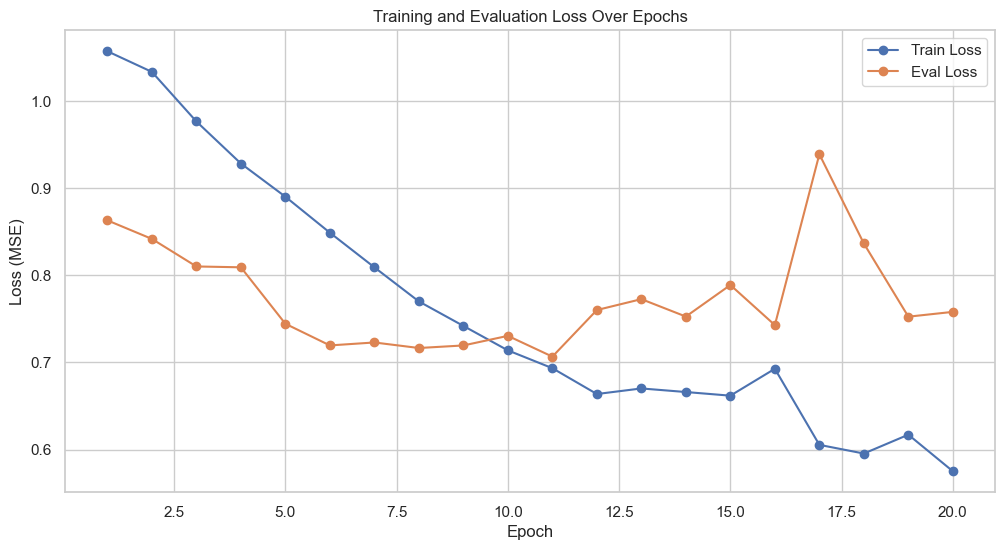

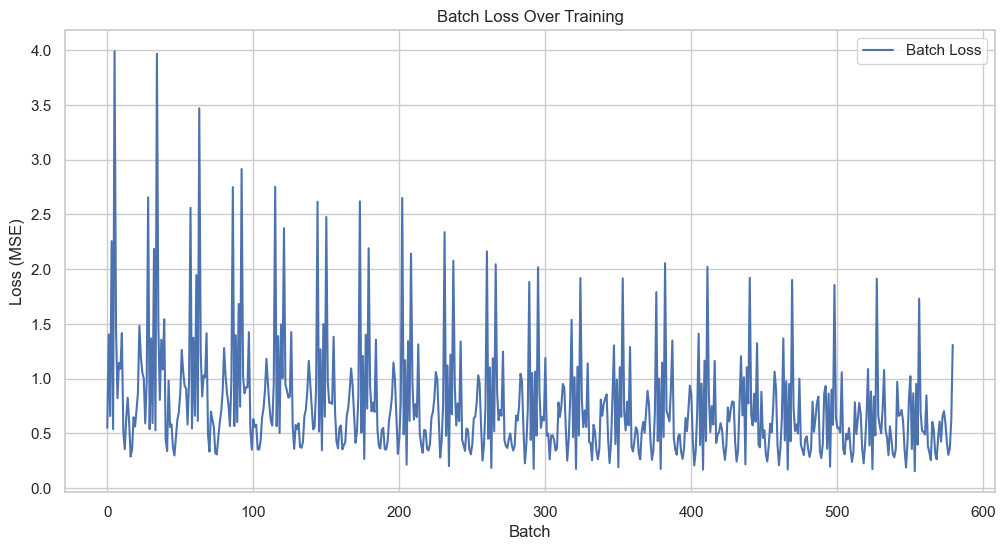

In [31]:
# Hyperparameters
input_dim = len(train_dataset.features)  # e.g., 24
hidden_dim = 64              # Number of LSTM units
num_layers = 2
output_dim = 1                   # For regression (predicting a single value)
num_epochs = 20
learning_rate = 0.001

# Initialize model, loss function, and optimizer
model = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Prepare lists to store loss values for plotting
train_epoch_losses = []
eval_epoch_losses = []
batch_losses = []

# Training and evaluation loop
for epoch in range(num_epochs):
    model.train()
    train_loss_epoch = 0.0

    # --- Training ---
    for batch in train_loader:
        x_features, x_id, y = batch  # x_features: [batch, seq_length, input_dim]
        
        # Forward pass
        outputs = model(x_features)  # outputs shape: [batch, output_dim]
        loss = criterion(outputs.squeeze(), y)

        batch_losses.append(loss.item())
        
        # Backprop and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss_epoch += loss.item()
    
    avg_train_loss = train_loss_epoch / len(train_loader)
    train_epoch_losses.append(avg_train_loss)
    
    # --- Evaluation ---
    model.eval()
    eval_loss_epoch = 0.0
    with torch.no_grad():
        for batch in test_loader:
            x_features, x_id, y = batch
            outputs = model(x_features)
            loss = criterion(outputs.squeeze(), y)
            eval_loss_epoch += loss.item()
    
    avg_eval_loss = eval_loss_epoch / len(test_loader)
    eval_epoch_losses.append(avg_eval_loss)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Eval Loss: {avg_eval_loss:.4f}")

# Plot the training and evaluation loss curves
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
plt.plot(range(1, num_epochs+1), train_epoch_losses, label='Train Loss', marker='o')
plt.plot(range(1, num_epochs+1), eval_epoch_losses, label='Eval Loss', marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.title("Training and Evaluation Loss Over Epochs")
plt.legend()
plt.show()

# plot batch losses
plt.figure(figsize=(12, 6))
plt.plot(batch_losses, label='Batch Loss')
plt.xlabel("Batch")
plt.ylabel("Loss (MSE)")
plt.title("Batch Loss Over Training")
plt.legend()
plt.show()


In [32]:

def predict_and_plot(model, data_loader, test_dataset, target_scaler=None, show_plot=True, save_html=True, title="predictions"):
    """
    Runs predictions on the data_loader using model, builds a results DataFrame using the
    test_dataset's original data (which includes the 'day' and 'id_num' columns), and then plots
    real vs predicted values with Plotly using the 'day' column for the x-axis and a dropdown
    to select different participants.

    Parameters:
        model: Trained PyTorch model.
        data_loader: DataLoader for the dataset to predict on.
        test_dataset: The dataset instance (e.g., MultiParticipantDataset) used to create data_loader.
                      It must have a 'data' attribute containing the original DataFrame with a 'day' column.
        target_scaler: (Optional) Scaler used to normalize the target data.
    """
    model.eval()
    all_predictions = []
    all_targets = []
    
    # Run model predictions over the data_loader
    with torch.no_grad():
        for batch in data_loader:
            x_features, x_id, y = batch
            outputs = model(x_features)
            all_predictions.append(outputs.cpu().numpy())
            all_targets.append(y.cpu().numpy())
    
    # Concatenate all predictions and targets into arrays.
    all_predictions = np.concatenate(all_predictions)
    all_targets = np.concatenate(all_targets)
    
    print("all_predictions shape:", all_predictions.shape)
    print("all_targets shape:", all_targets.shape)

    print("Before inverse transform:")
    print(np.mean(all_predictions), np.std(all_predictions))
    print(np.mean(all_targets), np.std(all_targets))

    
    # Inverse transform if a target scaler is provided.
    if target_scaler is not None:
        print("Target scaler mean:", target_scaler.mean_)
        print("Target scaler scale:", target_scaler.scale_)
        all_predictions = target_scaler.inverse_transform(all_predictions)
        all_targets = target_scaler.inverse_transform(all_targets.reshape(-1, 1))
    
    print("After inverse transform:")
    print("all_predictions shape:", all_predictions.shape)
    print("all_targets shape:", all_targets.shape) 
    
    print("after inverse transform:")
    print(np.mean(all_predictions), np.std(all_predictions))
    print(np.mean(all_targets), np.std(all_targets))
    # Compute the correct slice of the original DataFrame.
    # The i-th prediction corresponds to data row at index (i + seq_length)
    start_idx = test_dataset.seq_length
    end_idx = start_idx + len(test_dataset)
    df_results = test_dataset.data.iloc[start_idx:end_idx].copy().reset_index(drop=True)
    
    print("df_results shape:", df_results.shape)
    print(df_results.columns)
    
    # Add prediction and target columns to the results DataFrame.
    df_results['Real'] = all_targets.reshape(-1)
    df_results['Predicted'] = all_predictions.reshape(-1)
    

    
    # Get unique participant IDs from the results DataFrame.
    participant_col = test_dataset.id_col  # e.g., 'id_num'
    participants = df_results[participant_col].unique()
    
    # Build Plotly traces for each participant: two traces (real & predicted) per participant.
    traces = []
    for p in participants:
        df_p = df_results[df_results[participant_col] == p]
        traces.append(go.Scatter(
            x=df_p['day'],
            y=df_p['Real'],
            mode='lines',
            name=f'Real ({p})',
            visible=False  # We'll control visibility via the dropdown.
        ))
        traces.append(go.Scatter(
            x=df_p['day'],
            y=df_p['Predicted'],
            mode='lines',
            name=f'Predicted ({p})',
            visible=False
        ))
    
    total_traces = len(traces)  # Should be 2 * number of participants.
    
    # Create dropdown buttons. Each button sets visibility so that only the two traces for one participant are shown.
    dropdown_buttons = []
    for i, p in enumerate(participants):
        visibility = [False] * total_traces
        # For participant p, set traces at indices 2*i and 2*i+1 to True.
        visibility[2*i] = True
        visibility[2*i+1] = True
        button = dict(
            label=str(p),
            method="update",
            args=[{"visible": visibility},
                  {"title": f"Real vs Predicted Mood Values for Participant {p}",
                   "xaxis": {"title": "Day"},
                   "yaxis": {"title": "Mood Value"}}]
        )
        dropdown_buttons.append(button)
    
    # Set the initial visibility: show the first participant.
    initial_visibility = [False] * total_traces
    initial_visibility[0] = True
    initial_visibility[1] = True
    for i in range(total_traces):
        traces[i].visible = initial_visibility[i]
    
    # Build the figure with all traces and add the dropdown menu.
    fig = go.Figure(data=traces)
    fig.update_layout(
        updatemenus=[
            dict(
                active=0,
                buttons=dropdown_buttons,
                x=1.1,
                y=1.0,
                showactive=True
            )
        ],
        title=f"Real vs Predicted Mood Values for Participant {participants[0]}",
        xaxis_title="Day",
        yaxis_title="Mood Value"
    )
    
    if show_plot:
        fig.show()
    if save_html:
        outdir = "figures/plotly/predictions"
        os.makedirs(outdir, exist_ok=True)
        fig.write_html(os.path.join(outdir, f"predictions_{title}.html"))

# Call the function to predict and plot
predict_and_plot(model, train_loader, train_dataset, target_scaler=scaler_target, show_plot=True, save_html=True, title="train")
predict_and_plot(model, test_loader, test_dataset, target_scaler=scaler_target, show_plot=True, save_html=True, title="test")

all_predictions shape: (915, 1)
all_targets shape: (915,)
Before inverse transform:
0.16062155 0.64707756
-0.002992632 1.0094156
Target scaler mean: [7.01492034]
Target scaler scale: [0.73202915]
After inverse transform:
all_predictions shape: (915, 1)
all_targets shape: (915, 1)
after inverse transform:
7.1324997 0.47367957
7.0127296 0.7389217
df_results shape: (915, 26)
Index(['id_num', 'mood', 'screen', 'activity', 'activity_max',
       'circumplex.valence', 'circumplex.valence_min',
       'circumplex.valence_max', 'circumplex.arousal',
       'circumplex.arousal_min', 'circumplex.arousal_max', 'call', 'sms',
       'appCat.builtin', 'appCat.communication', 'appCat.entertainment',
       'appCat.finance', 'appCat.game', 'appCat.office', 'appCat.other',
       'appCat.social', 'appCat.travel', 'appCat.unknown', 'appCat.utilities',
       'appCat.weather', 'day'],
      dtype='object', name='variable')


all_predictions shape: (163, 1)
all_targets shape: (163,)
Before inverse transform:
0.18566108 0.6222389
0.08612346 1.0123131
Target scaler mean: [7.01492034]
Target scaler scale: [0.73202915]
After inverse transform:
all_predictions shape: (163, 1)
all_targets shape: (163, 1)
after inverse transform:
7.1508293 0.45549703
7.077965 0.7410427
df_results shape: (163, 26)
Index(['id_num', 'mood', 'screen', 'activity', 'activity_max',
       'circumplex.valence', 'circumplex.valence_min',
       'circumplex.valence_max', 'circumplex.arousal',
       'circumplex.arousal_min', 'circumplex.arousal_max', 'call', 'sms',
       'appCat.builtin', 'appCat.communication', 'appCat.entertainment',
       'appCat.finance', 'appCat.game', 'appCat.office', 'appCat.other',
       'appCat.social', 'appCat.travel', 'appCat.unknown', 'appCat.utilities',
       'appCat.weather', 'day'],
      dtype='object', name='variable')
